In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda


In [2]:
# =============================================================================
# CELL 2: Configuration
# =============================================================================

# Paths (Adjust as needed)
PATH_PASTIS = Path('PASTIS/DATA_S2')  # Raw PASTIS data
PATH_ALGERIA_CEREAL = Path('output/algeria_s2_data/DATA_S2')
PATH_ALGERIA_ANN = Path('output/algeria_s2_data/ANNOTATIONS')
PATH_ALGERIA_POTATO = Path('output/potato_inference_data')

CONFIG = {
    'batch_size': 32,
    'learning_rate': 1e-5,
    'weight_decay': 0.05,
    'epochs': 20,
    'img_size': 128,
    'in_channels': 10,
    'fda_beta': 0.05, # Strength of domain adaptation
}

In [3]:
# =============================================================================
# CELL 3: FDA (Fourier Domain Adaptation) Function
# =============================================================================

def extract_spectrum(img_np):
    """Computes FFT of the image (amplitude and phase)"""
    # img_np shape: (C, H, W)
    fft = np.fft.fft2(img_np, axes=(-2, -1))
    amplitude = np.abs(fft)
    phase = np.angle(fft)
    return amplitude, phase

def apply_fda(source_img, target_img, beta=0.01):
    """
    Transfers the low-frequency style (amplitude) from target to source.
    """
    # 1. Get FFT of both
    src_amp, src_phase = extract_spectrum(source_img)
    trg_amp, _ = extract_spectrum(target_img)
    
    # 2. Define low-frequency window
    c, h, w = source_img.shape
    b = int(np.floor(min(h, w) * beta))
    center_h, center_w = int(h/2), int(w/2)
    
    # 3. Swap low-freq amplitude (Style Transfer)
    # Shift FFT so low freq is in center
    src_amp_shifted = np.fft.fftshift(src_amp, axes=(-2, -1))
    trg_amp_shifted = np.fft.fftshift(trg_amp, axes=(-2, -1))
    
    # Replace center (low freq) of source with target
    src_amp_shifted[:, center_h-b:center_h+b, center_w-b:center_w+b] = \
        trg_amp_shifted[:, center_h-b:center_h+b, center_w-b:center_w+b]
    
    # Shift back
    new_amp = np.fft.ifftshift(src_amp_shifted, axes=(-2, -1))
    
    # 4. Reconstruct
    new_fft = new_amp * np.exp(1j * src_phase)
    new_img = np.abs(np.fft.ifft2(new_fft, axes=(-2, -1)))
    
    return np.clip(new_img, 0, 1).astype(np.float32)

In [4]:
def create_swin_binary(in_channels=10, num_classes=1, pretrained=False, img_size=128):
    model = timm.create_model(
        'swin_tiny_patch4_window7_224', # Use 128 size version if available, else 224 and resize
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=img_size,
    )
    
    # Patch Embedding Hack for 10 Channels
    original_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=CONFIG['in_channels'],
        out_channels=original_proj.out_channels,
        kernel_size=original_proj.kernel_size,
        stride=original_proj.stride,
        padding=original_proj.padding
    )
    
    with torch.no_grad():
        new_proj.weight[:, :3, :, :] = original_proj.weight
        mean_weight = torch.mean(original_proj.weight, dim=1, keepdim=True)
        new_proj.weight[:, 3:, :, :] = mean_weight.repeat(1, 7, 1, 1)
        new_proj.bias.copy_(original_proj.bias)
        
    model.patch_embed.proj = new_proj
    return model

model = create_swin_binary().to(device)

In [5]:
# =============================================================================
# CELL 4: Dataset Classes
# =============================================================================

# --- 1. PASTIS DATASET (The "Teacher" Data - FDA Adapted) ---
class PastisDataset(Dataset):
    def __init__(self, data_dir, target_style_images=None):
        self.files = sorted(list(data_dir.glob('*.npy')))
        self.target_style_images = target_style_images # List of Algeria images for FDA
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        try:
            full_ts = np.load(path)
            if full_ts.ndim == 4:
                # Simple Max-NDVI selection on the fly
                # NDVI = (B8 - B4) / (B8 + B4) -> B8 is index 6, B4 is index 2
                b8 = full_ts[:, 6, :, :]
                b4 = full_ts[:, 2, :, :]
                ndvi = (b8 - b4) / (b8 + b4 + 1e-6)
                mean_ndvi = ndvi.mean(axis=(1, 2))
                best_idx = np.argmax(mean_ndvi)
                img = full_ts[best_idx].astype(np.float32)
            else:
                img = full_ts.astype(np.float32)
            
            img = img / 10000.0
            img = np.clip(img, 0, 1)

            # --- APPLY FDA (Domain Adaptation) ---
            if self.target_style_images is not None and len(self.target_style_images) > 0:
                target_idx = random.randint(0, len(self.target_style_images)-1)
                target_img = self.target_style_images[target_idx]
                img = apply_fda(img, target_img, beta=CONFIG['fda_beta'])
            
            # Label 1 (We treat PASTIS crops as Positive training examples)
            return torch.from_numpy(img), torch.tensor(1.0, dtype=torch.float32)
            
        except Exception as e:
            return torch.zeros((10, 128, 128)), torch.tensor(0.0)

# --- 2. ALGERIA MIXED DATASET (Cereal + Potato) ---
class AlgeriaMixedDataset(Dataset):
    def __init__(self, cereal_files, potato_files, cereal_ann_dir):
        self.files = cereal_files + potato_files
        self.cereal_ann_dir = cereal_ann_dir
        self.potato_files_set = set(potato_files) # For fast lookup

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = np.load(path).astype(np.float32)
        if img.ndim == 4: img = img[0]
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        # --- DETERMINE LABEL (BINARY: Crop vs No-Crop) ---
        label_val = 0.0
        
        if path in self.potato_files_set:
            # Logic for Potato Files: _P1_ is Potato (Crop), _P0_ is Non-Potato (Background)
            if '_P1_' in path.name:
                label_val = 1.0
            else:
                label_val = 0.0
        else:
            # Logic for Cereal Files (Check Annotation)
            fid = path.stem.replace('S2_', '')
            ann_path = self.cereal_ann_dir / f"Labels_{fid}.npy"
            if ann_path.exists():
                ann = np.load(ann_path)
                # If mask has any crop class (1, 2, 3..), it's Crop. 0 is Background.
                max_class = ann.max()
                if max_class > 0:
                    label_val = 1.0
                else:
                    label_val = 0.0
            else:
                label_val = 0.0 # Default background
        
        return torch.from_numpy(img), torch.tensor(label_val, dtype=torch.float32)

In [6]:
# =============================================================================
# CELL 5: Data Loading & Splitting
# =============================================================================

# 1. Gather Files
cereal_files = sorted(list(PATH_ALGERIA_CEREAL.glob('*.npy')))
potato_files = sorted(list(PATH_ALGERIA_POTATO.glob('S2_*.npy')))

# 2. Split Algeria Data (Train vs Test)
# Cereal Split (Standard < 100 logic from previous notebook)
cereal_train = [f for f in cereal_files if int(f.stem.split('_')[1]) <= 100]
cereal_test = [f for f in cereal_files if int(f.stem.split('_')[1]) > 100]

# Potato Split (Random Tile Split - No Poly Logic as requested)
pot_train, pot_test = train_test_split(potato_files, test_size=0.5, random_state=42, shuffle=True)

print(f"Cereal: {len(cereal_train)} Train, {len(cereal_test)} Test")
print(f"Potato: {len(pot_train)} Train, {len(pot_test)} Test")
# 3. Load Target Images for FDA (Use Algeria Train images as style targets)
style_refs = []
print("Loading style references for FDA...")
for f in (cereal_train + pot_train)[:50]: # Take 50 random samples
    img = np.load(f).astype(np.float32)
    if img.ndim == 4: img = img[0]
    img = img / 10000.0
    style_refs.append(np.clip(img, 0, 1))

# 4. Instantiate Datasets
ds_pastis = PastisDataset(PATH_PASTIS, target_style_images=style_refs)
ds_algeria_train = AlgeriaMixedDataset(cereal_train, pot_train, PATH_ALGERIA_ANN)
ds_algeria_test = AlgeriaMixedDataset(cereal_test, pot_test, PATH_ALGERIA_ANN)

# 5. Hybrid DataLoader (50% FDA, 50% Real)
class HybridDataLoader:
    def __init__(self, fda_dataset, real_dataset, batch_size=32, shuffle=True):
        self.fda_dataset = fda_dataset
        self.real_dataset = real_dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.fda_per_batch = batch_size // 2
        self.real_per_batch = batch_size - self.fda_per_batch
        
        self.fda_indices = list(range(len(fda_dataset)))
        self.real_indices = list(range(len(real_dataset)))
        self.num_batches = len(fda_dataset) // self.fda_per_batch # Oversample real to match FDA
        
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.fda_indices)
            random.shuffle(self.real_indices)
        
        fda_ptr = 0
        real_ptr = 0
        
        for _ in range(self.num_batches):
            batch_imgs = []
            batch_labels = []
            
            # FDA Samples
            for _ in range(self.fda_per_batch):
                if fda_ptr >= len(self.fda_indices):
                    fda_ptr = 0
                    if self.shuffle: random.shuffle(self.fda_indices)
                img, label = self.fda_dataset[self.fda_indices[fda_ptr]]
                batch_imgs.append(img)
                batch_labels.append(label)
                fda_ptr += 1
            
            # Real Samples
            for _ in range(self.real_per_batch):
                if real_ptr >= len(self.real_indices):
                    real_ptr = 0
                    if self.shuffle: random.shuffle(self.real_indices)
                img, label = self.real_dataset[self.real_indices[real_ptr]]
                batch_imgs.append(img)
                batch_labels.append(label)
                real_ptr += 1
                
            # Stack
            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.stack(batch_labels)
            
            # Shuffle batch
            perm = torch.randperm(len(batch_imgs))
            yield batch_imgs[perm], batch_labels[perm]

    def __len__(self):
        return self.num_batches

train_loader = HybridDataLoader(ds_pastis, ds_algeria_train, batch_size=CONFIG['batch_size'])
test_loader = DataLoader(ds_algeria_test, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"\nFINAL DATA SETUP:")
print(f"  Training: ~{len(train_loader) * CONFIG['batch_size']} samples (Hybrid)")
print(f"  Testing:  {len(ds_algeria_test)} samples (Algeria Only)")


Cereal: 100 Train, 93 Test
Potato: 42 Train, 43 Test
Loading style references for FDA...

FINAL DATA SETUP:
  Training: ~4928 samples (Hybrid)
  Testing:  136 samples (Algeria Only)


In [7]:
# =============================================================================
# CELL 6: Swin Model Definition
# =============================================================================

def create_swin_binary():
    # Use standard 224 model and adapt
    model = timm.create_model(
        'swin_tiny_patch4_window7_224', 
        pretrained=True,
        num_classes=1, # Binary
        in_chans=3,
        img_size=128
    )
    
    # Patch Embedding Hack for 10 Channels
    original_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=CONFIG['in_channels'],
        out_channels=original_proj.out_channels,
        kernel_size=original_proj.kernel_size,
        stride=original_proj.stride,
        padding=original_proj.padding
    )
    
    with torch.no_grad():
        new_proj.weight[:, :3, :, :] = original_proj.weight
        mean_weight = torch.mean(original_proj.weight, dim=1, keepdim=True)
        new_proj.weight[:, 3:, :, :] = mean_weight.repeat(1, 7, 1, 1)
        new_proj.bias.copy_(original_proj.bias)
        
    model.patch_embed.proj = new_proj
    return model

model = create_swin_binary().to(device)
print("Model created successfully.")

Model created successfully.


/home/crop/Desktop/crop2/myenv/lib/python3.12/site-packages/timm/layers/interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  idx_right = torch.bucketize(x, p)
/home/crop/Desktop/crop2/myenv/lib/python3.12/site-packages/timm/layers/interpolate.py:65: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  numerator += self.values[as_s] *

In [8]:
# =============================================================================
# CELL 7: Training Loop
# =============================================================================

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

best_acc = 0.0
history = {'train_loss': [], 'val_acc': []}

print("Starting Training Pipeline...")
for epoch in range(CONFIG['epochs']):
    # --- Train ---
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    # --- Validation ---
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Acc {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_binary_crop_model.pth')
        print("  >>> New Best Model Saved")
        
    scheduler.step()

Starting Training Pipeline...


Epoch 1: Train Loss 0.1936 | Val Acc 0.7647
  >>> New Best Model Saved


Epoch 2: Train Loss 0.0154 | Val Acc 0.8015
  >>> New Best Model Saved


Epoch 3: Train Loss 0.0099 | Val Acc 0.7794


Epoch 4: Train Loss 0.0041 | Val Acc 0.7794


Epoch 5: Train Loss 0.0080 | Val Acc 0.7206


Epoch 6: Train Loss 0.0052 | Val Acc 0.7721


Epoch 7: Train Loss 0.0026 | Val Acc 0.7500


Epoch 8: Train Loss 0.0016 | Val Acc 0.7794


Epoch 9: Train Loss 0.0017 | Val Acc 0.7721


Epoch 10: Train Loss 0.0033 | Val Acc 0.7721


Epoch 11: Train Loss 0.0084 | Val Acc 0.7574


Epoch 12: Train Loss 0.0036 | Val Acc 0.7941


Epoch 13: Train Loss 0.0022 | Val Acc 0.7868


Epoch 14: Train Loss 0.0066 | Val Acc 0.7794


KeyboardInterrupt: 


Running Full Evaluation on Combined Test Set...

FINAL RESULTS: CROP (Cereal+Potato) vs NO-CROP
              precision    recall  f1-score   support

     No-Crop       0.83      0.80      0.81        74
        Crop       0.77      0.81      0.79        62

    accuracy                           0.80       136
   macro avg       0.80      0.80      0.80       136
weighted avg       0.80      0.80      0.80       136



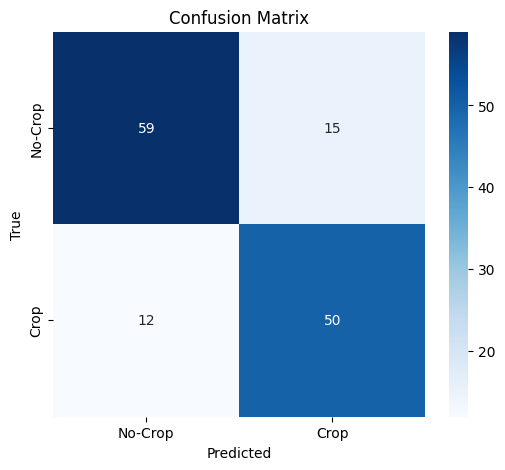

In [9]:
# =============================================================================
# CELL 8: Final Evaluation
# =============================================================================

# Load Best Model
model.load_state_dict(torch.load('best_binary_crop_model.pth'))
model.eval()

y_true = []
y_pred = []

print("\nRunning Full Evaluation on Combined Test Set...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n" + "="*50)
print("FINAL RESULTS: CROP (Cereal+Potato) vs NO-CROP")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['No-Crop', 'Crop']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No-Crop', 'Crop'], yticklabels=['No-Crop', 'Crop'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
import itertools
import time
import copy

# --- 1. Define Hyperparameter Grid ---
param_grid = {
    'learning_rate': [1e-5],
    'weight_decay': [0.05],
    'drop_rate': [0.3],          # Head Dropout
    'fda_beta': [0.05]          # Domain Adaptation Strength
}

# Generate combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"🚀 Starting Optimized Grid Search over {len(combinations)} configurations...")
print(f"GPUs Available: {torch.cuda.device_count()}")
print(f"Constraint: Max 8 Epochs per run + Early Stopping.")

# Storage for results
results = []
best_overall_acc = 0.0
best_config = {}

start_total = time.time()

# --- 2. Grid Search Loop ---
for i, config in enumerate(combinations):
    run_start = time.time()
    print(f"\n[Run {i+1}/{len(combinations)}] Config: {config}")
    
    # A. Setup Data (Update FDA Beta globally)
    CONFIG['fda_beta'] = config['fda_beta'] 
    
    # Re-init Pastis to ensure beta is applied correctly if cached (though mostly dynamic)
    # Note: Removed 'transform' argument to match your original class definition
    current_ds_pastis = PastisDataset(PATH_PASTIS, target_style_images=style_refs)
    grid_train_loader = HybridDataLoader(current_ds_pastis, ds_algeria_train, batch_size=32)
    
    # B. Initialize Model
    model = timm.create_model(
        'swin_tiny_patch4_window7_224', 
        pretrained=True, 
        num_classes=1, 
        in_chans=3,
        img_size=128,
        drop_rate=config['drop_rate']
    )
    
    # 10-Channel Patch Embedding Fix
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(10, orig_proj.out_channels, kernel_size=orig_proj.kernel_size, stride=orig_proj.stride, padding=orig_proj.padding)
    with torch.no_grad():
        new_proj.weight[:, :3] = orig_proj.weight
        new_proj.weight[:, 3:] = torch.mean(orig_proj.weight, dim=1, keepdim=True).repeat(1, 7, 1, 1)
        new_proj.bias.copy_(orig_proj.bias)
    model.patch_embed.proj = new_proj
    
    # Dual GPU Support
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # C. Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.BCEWithLogitsLoss()
    
    # D. Fast Training Loop with Early Stopping
    MAX_EPOCHS = 8
    PATIENCE = 3
    best_run_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Train
        model.train()
        for imgs, lbls in grid_train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            
        # Validation (Strictly for Model Selection)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, lbls in test_loader: # using test_loader as validation set here
                imgs, lbls = imgs.to(device), lbls.to(device).unsqueeze(1)
                outputs = model(imgs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)
        
        val_acc = correct / total
        
        # Check Best for this Run
        if val_acc > best_run_val_acc:
            best_run_val_acc = val_acc
            patience_counter = 0 # Reset patience
        else:
            patience_counter += 1
            
        # Early Stopping Trigger
        if patience_counter >= PATIENCE:
            # print(f"   -> Early stopping at epoch {epoch+1}")
            break
            
    run_time = time.time() - run_start
    print(f"   -> Result: Val Acc {best_run_val_acc:.4f} | Time: {run_time:.1f}s")
    
    # Record Result
    results.append({'config': config, 'acc': best_run_val_acc})
    
    # E. Save Global Best
    if best_run_val_acc > best_overall_acc:
        best_overall_acc = best_run_val_acc
        best_config = config
        print(f"   🌟 New Global Best! Saving model...")
        
        # Handle DataParallel wrapper for saving
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, 'best_grid_search_model.pth')

total_time = (time.time() - start_total) / 60
print("\n" + "="*50)
print(f"🏆 GRID SEARCH COMPLETE in {total_time:.1f} minutes")
print(f"Best Validation Accuracy: {best_overall_acc:.4f}")
print(f"Best Config: {best_config}")
print("="*50)

🚀 Starting Optimized Grid Search over 1 configurations...
GPUs Available: 2
Constraint: Max 8 Epochs per run + Early Stopping.

[Run 1/1] Config: {'learning_rate': 1e-05, 'weight_decay': 0.05, 'drop_rate': 0.3, 'fda_beta': 0.05}


/home/crop/Desktop/crop2/myenv/lib/python3.12/site-packages/timm/layers/interpolate.py:65: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  numerator += self.values[as_s] * \


   -> Result: Val Acc 0.8603 | Time: 345.8s
   🌟 New Global Best! Saving model...

🏆 GRID SEARCH COMPLETE in 5.8 minutes
Best Validation Accuracy: 0.8603
Best Config: {'learning_rate': 1e-05, 'weight_decay': 0.05, 'drop_rate': 0.3, 'fda_beta': 0.05}


In [23]:
# --- Load and Evaluate the Champion Model ---
print(f"Loading best model found with config: {best_config}")

# Re-build model structure to match saved weights
best_model = timm.create_model(
    'swin_tiny_patch4_window7_224', 
    pretrained=False, # Weights loaded from disk
    num_classes=1, 
    in_chans=10,
    img_size=128,
    drop_rate=0,
    learning_rate=best_config['learning_rate'],
    weight_decay=best_config['weight_decay'],
    fda_beta = 0.05 
)

# Fix Input Layer
orig_proj = best_model.patch_embed.proj
new_proj = nn.Conv2d(10, orig_proj.out_channels, kernel_size=orig_proj.kernel_size, stride=orig_proj.stride, padding=orig_proj.padding)
best_model.patch_embed.proj = new_proj

# Load Weights
best_model.load_state_dict(torch.load('best_grid_search_model.pth'))
best_model.to(device)
best_model.eval()

# Run Inference
y_true = []
y_pred = []

print("Running Final Evaluation...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n" + "="*50)
print("WINNER MODEL RESULTS")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['No-Crop', 'Crop']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Loading best model found with config: {'learning_rate': 1e-05, 'weight_decay': 0.05, 'drop_rate': 0.3, 'fda_beta': 0.05}
Running Final Evaluation...

WINNER MODEL RESULTS
              precision    recall  f1-score   support

     No-Crop       0.83      0.85      0.84        74
        Crop       0.82      0.79      0.80        62

    accuracy                           0.82       136
   macro avg       0.82      0.82      0.82       136
weighted avg       0.82      0.82      0.82       136

Confusion Matrix:
[[63 11]
 [13 49]]
